In [1]:
import confirm.berrylib.util as util
util.setup_nb(pretty=False)

from scipy.special import logit, expit
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import warnings
# import pyimprint.grid as grid
import confirm.berrylib.fast_inla as fast_inla
import confirm.mini_imprint.binomial as binomial
import confirm.mini_imprint.grid as grid

import jax
# set to cpu or gpu to run on a specific device.
# jax.config.update('jax_platform_name', 'gpu')

def chunked_simulate(g, sim_size, gridpt_chunk_size=5000, sim_chunk_size=50000):
    theta_tiles = g.theta_tiles
    typeI_sum = np.zeros(theta_tiles.shape[0])
    typeI_score = np.zeros((theta_tiles.shape[0], n_arms))
    n_gridpt_chunks = int(np.ceil(theta_tiles.shape[0] / gridpt_chunk_size))
    n_sim_chunks = int(np.ceil(sim_size / sim_chunk_size))

    for j in range(n_sim_chunks):
        start_sims = j * sim_chunk_size
        end_sims = min(start_sims + sim_chunk_size, sim_size)
        nsims_this_chunk = end_sims - start_sims
        samples = np.random.uniform(size=(nsims_this_chunk, n_arm_samples, n_arms))
        for i in range(n_gridpt_chunks):
            gridpt_start = i * gridpt_chunk_size
            gridpt_end = (i + 1) * gridpt_chunk_size
            gridpt_end = min(gridpt_end, theta_tiles.shape[0])
            sum_chunk, score_chunk = accumulator(
                theta_tiles[gridpt_start:gridpt_end],
                g.null_truth[gridpt_start:gridpt_end],
                samples
            )
            typeI_sum[gridpt_start:gridpt_end] += sum_chunk
            typeI_score[gridpt_start:gridpt_end] += score_chunk
    return typeI_sum, typeI_score

# total, d0, d0u, d1w, d1uw, d2uw = binomial.upper_bound(
#     g.theta_tiles,
#     g.radii[g.grid_pt_idx],
#     g.vertices,
#     np.full(g.n_tiles, sim_size),
#     n_arm_samples,
#     typeI_sum,
#     typeI_score,
# )

In [2]:
import matplotlib as mpl

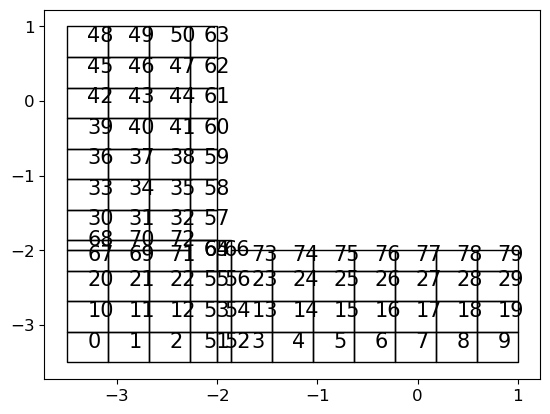

In [3]:
n_arms = 2
n_theta_1d = 11

null_hypos = [grid.HyperPlane(-np.identity(n_arms)[i], 2) for i in range(n_arms)]
theta1d = [np.linspace(-3.5, 1.0, 2 * n_theta_1d + 1)[1::2] for i in range(n_arms)]
theta = np.stack(np.meshgrid(*theta1d), axis=-1).reshape((-1, len(theta1d)))
radii = np.empty(theta.shape)
for i in range(theta.shape[1]):
    radii[:, i] = 0.5 * (theta1d[i][1] - theta1d[i][0])
g = grid.prune(grid.build_grid(theta, radii, null_hypos))
grid.plot_grid2d(g)#, null_hypos)

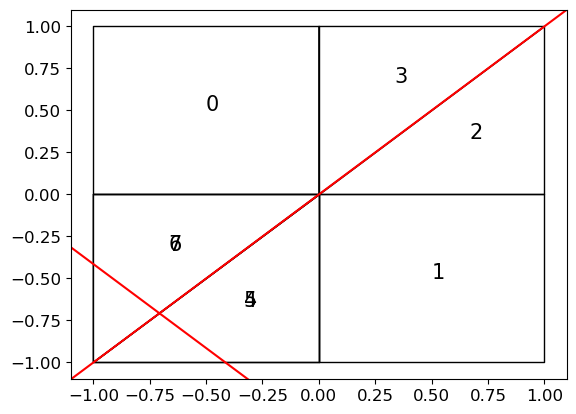

In [4]:
thetas = np.array([[-0.5, -0.5], [-0.5, 0.5], [0.5, -0.5], [0.5, 0.5]])
radii = np.full_like(thetas, 0.5)
def normalize(n):
    return n / np.linalg.norm(n)
hypos = [
    grid.HyperPlane(normalize(np.array([1, -1])), 0),
    grid.HyperPlane(normalize(np.array([1, 1])), -1),
]
g = grid.build_grid(thetas, radii, hypos)
grid.plot_grid2d(g, hypos)

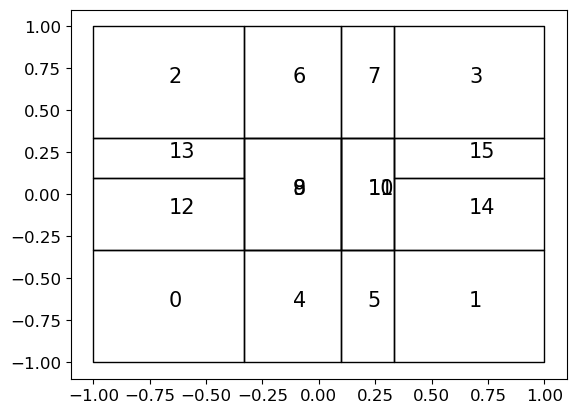

In [5]:
theta, radii = grid.cartesian_gridpts([-1, -1], [1, 1], [3, 3])
null_hypos = [grid.HyperPlane(-np.identity(2)[i], -0.1) for i in range(2)]
g = grid.build_grid(theta, radii, null_hypos)
grid.plot_grid2d(g)

In [6]:
g.vertices[1]

array([[ 1.        , -0.33333333],
       [ 1.        , -1.        ],
       [ 0.33333333, -0.33333333],
       [ 0.33333333, -1.        ]])

In [7]:
LL = np.arange(10)
LL[LL.shape[0] - 5:]

array([5, 6, 7, 8, 9])

In [8]:
10 - 5

5

In [9]:
%%time
n_arms = 2
n_arm_samples = 35
fi = fast_inla.FastINLA(n_arms=n_arms, critical_value=0.99)
rejection_table = binomial.build_rejection_table(n_arms, n_arm_samples, fi.rejection_inference)
accumulator = binomial.binomial_accumulator(lambda data: binomial.lookup_rejection(rejection_table, data[...,0]))

CPU times: user 1.43 s, sys: 133 ms, total: 1.56 s
Wall time: 1.54 s


In [10]:
n_theta_1d = 4
theta_min = -3.5
theta_max = 1.0

null_hypos = [
    grid.HyperPlane(-np.identity(n_arms)[i], -logit(0.1)) for i in range(n_arms)
]
theta, radii = grid.cartesian_gridpts(
    np.full(n_arms, theta_min), np.full(n_arms, theta_max), np.full(n_arms, n_theta_1d)
)
g_raw = grid.build_grid(theta, radii)
start_grid = grid.prune(grid.intersect_grid(g_raw, null_hypos))

In [11]:
seed = 10
sim_size = 100000
delta = 0.025

In [12]:
# stop adagrid whenever hob is below this
target_bound = 0.02

# if we can't get below 0.1, refine until the edges are less than 20% above the
# sim pt
target_grid_rel_bound = 0.1

# if we can't get below 0.1, refine until the edges are less than 20% above the
# sim pt
target_sim_rel_bound = 0.2
N_max = int(2e5)

iter_max = 9


In [13]:
def dots_plot(g, typeI_upper_bound, hob):
    plt.subplots(1, 2, figsize=(7, 3.0), constrained_layout=True)
    plt.subplot(1,2,1)
    plt.scatter(g.theta_tiles[:,0], g.theta_tiles[:, 1], c=hob, s=10)
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.scatter(g.theta_tiles[:,0], g.theta_tiles[:, 1], c=typeI_upper_bound, s=10)
    plt.colorbar()
    plt.show()

def dots_plot2(g, typeI_upper_bound, hob):
    plt.scatter(g.theta_tiles[:,0], g.theta_tiles[:, 1], c=hob, s=10)
    plt.colorbar()

In [18]:
# TODO: don't recompute for unrefined.
# TODO: refine n_sims too! 
# TODO: why is this slow??
plt.subplots(3, 3, figsize=(10, 10.0), constrained_layout=True)
new_grid = start_grid
unrefined_grid = None
for ada_i in range(iter_max):
    # TODO: is setting the seed inside the loop okay?
    np.random.seed(seed)
    new_typeI_sum, _ = chunked_simulate(new_grid, sim_size)
    if unrefined_grid is not None:
        g = grid.concat_grids(new_grid, unrefined_grid)
        typeI_sum = np.concatenate((unrefined_typeI_sum, new_typeI_sum))
    else:
        g = new_grid
        typeI_sum = new_typeI_sum
    print(ada_i, new_grid.n_tiles, g.n_tiles)
    typeI_sum, _ = chunked_simulate(g, sim_size)

    typeI_est, typeI_CI = binomial.zero_order_bound(typeI_sum, sim_size, delta, 1.0)
    typeI_upper_bound = typeI_est + typeI_CI
    typeI_lower_bound = scipy.stats.beta.ppf(
        1 - delta, typeI_sum, sim_size - typeI_sum + 1
    )
    typeI_lower_bound = np.where(np.isnan(typeI_lower_bound), 0, typeI_lower_bound)

    hob_upper = binomial.holder_odi_bound(
        typeI_upper_bound, g.theta_tiles, g.vertices, n_arm_samples, 6
    )
    hob_lower = 1 - binomial.holder_odi_bound(
        1 - typeI_lower_bound, g.theta_tiles, g.vertices, n_arm_samples, 6
    )
    print(np.min(hob_upper), np.max(hob_lower))

    plt.subplot(3,3,ada_i+1)
    dots_plot2(g, typeI_upper_bound, hob_upper)
    if ada_i == iter_max - 1:
        break

    need_more_sims = typeI_upper_bound > target_bound
    likely_to_fail = typeI_lower_bound > target_bound
    more_sims = (typeI_upper_bound > target_bound) & (target_bound > typeI_lower_bound)

    # criterion = ((hob - typeI_upper_bound) / typeI_upper_bound > target_grid_rel_bound) & (
    #     hob > target_bound
    # )
    criterion = hob_upper > np.max(hob_lower) - 0.01
    refine_tile_idxs = np.where(criterion)
    if refine_tile_idxs[0].shape[0] == 0:
        print('done because no refinement')
        break

    new_thetas, new_radii, unrefined_grid, keep_tile_idxs = grid.refine_grid(
        g, g.grid_pt_idx[refine_tile_idxs]
    )
    new_grid = grid.prune(grid.build_grid(new_thetas, new_radii, null_hypos))
    unrefined_typeI_sum = typeI_sum[keep_tile_idxs]
plt.show()

0 16 16
0.1649272041161282 -10.925548609839902
1 67 67
0.0035945956985602504 -2.1219237210410298
2 281 281
0.00044968027573463715 -0.7175529589046117
3 1360 1360
0.00013785643953700808 -0.30101630053644435
4 6065 6065
7.273057858994805e-05 -0.13851853809806047
5 28144 28144
5.2074069281076755e-05 -0.06651985660365378
6 125513 125513
4.388932880566258e-05 -0.010554762496078895


In [44]:
(4.5 / g.radii.min()) ** 2 / 21580

48.59017608897127